In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit,minimize
import scipy
%matplotlib inline
from tqdm.auto import tqdm
import matplotlib.patheffects as pe
import quaternion as quat

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

COLOR = 'k'#'#FFFAF1'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 14 #12
plt.rcParams['ytick.major.size']  = 14#12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 8
plt.rcParams['ytick.minor.size']  = 8

plt.rcParams

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'
from matplotlib.gridspec import GridSpec

figaspectratio = 1.25

In [2]:
def chi2(x,y,sy):
    return(np.sum(np.square(x-y)/sy**2))

def fixed_axis_lightcurve(theta,a,b,c):
    dist=np.abs(np.sin(theta)*np.tan(theta)*a**2+c**2*np.cos(theta))
    beta=np.sqrt(c**2+a**2*np.tan(theta)**2)

    return(np.pi*b*dist/beta)

def fixedHfunction(time,p,betainit,deltaV):
    p=p/24
    beta=2*np.pi*((time-np.min(time))%p)/p
    curve=deltaV-2.5*np.log10(fixed_axis_lightcurve(beta-betainit,115,111,19))
    return(curve)

def arbitrary_axis_lightcurve(theta,a,b,c,rot=[0,1,0],obs=[1,0,0],N=250):
    ndata=theta.size
    obs=np.quaternion(0,*obs)
    
    # Generate x,y points
    x=np.linspace(-a,a,N)
    y=np.linspace(-b,b,N)
    
    X,Y=np.meshgrid(x,y,indexing='ij')
    
    # Remove the points outside of bounds
    pts_in=np.where(X**2/a**2+Y**2/b**2<=1)
    X=X[pts_in]
    Y=Y[pts_in]
    
    # Generate z points for the x and y points
    z=c*np.sqrt(np.abs(1-X**2/a**2-Y**2/b**2))
    
    # Get +/- z points
    x=np.append(X,X)
    y=np.append(Y,Y)
    z=np.append(z,-z)
    
    npts=z.size
    
    # Combine points
    pts=np.array([x,y,z]).T
    pts=np.tile(pts[:,:,np.newaxis],ndata)
        
    rot=rot/np.sqrt(np.sum(np.square(rot)))
    nrot=np.outer(np.array(rot),np.sin(theta/2))
    nrot=np.append(np.cos(theta[np.newaxis,:]/2),nrot,axis=0)
    
    q=quat.as_quat_array(nrot.T)
    q*=1/np.abs(q)
    
    obs=np.conj(q)*obs*q
    obs=quat.as_float_array(obs)[:,1:]
    
    obs=np.repeat(obs.T[np.newaxis,:,:],npts,axis=0)
    
    inner=np.sum(pts*obs,axis=1)
    inner=np.repeat(inner[:,np.newaxis,:],3,axis=1)
    
    proj=pts-inner*obs
    proj=np.append(np.zeros((npts,ndata))[:,np.newaxis,:],proj,axis=1)    
    
    proj=np.moveaxis(proj,1,2)
    proj=quat.as_quat_array(proj)
    
    q=np.repeat(q[np.newaxis,:],npts,axis=0)
    
    proj=q*proj*np.conj(q)
    proj=quat.as_float_array(proj)
    proj=proj[:,:,2:]
    
    output=[]
    for i in tqdm(range(ndata),desc='Hull Loop',leave=True):
        hull=scipy.spatial.ConvexHull(proj[:,i,:])
        output.append(hull.volume)
        
    return(np.array(output))

def arbitraryHfunction(time,p,phi,psi,betainit,deltaV):
    p=p/24
    beta=2*np.pi*((time-np.min(time))%p)/p
    
    rot=[np.cos(phi),np.sin(phi)*np.cos(psi),np.sin(phi)*np.sin(psi)]
    curve=deltaV-2.5*np.log10(arbitrary_axis_lightcurve(beta-betainit,115,111,19,rot=rot,N=50))
    return(curve)

def evolving_axis_lightcurve(theta,phi,psi,a,b,c,alpha,beta,sun=[1,0,0]): 
    import warnings
    warnings.filterwarnings("ignore")
    
    if isinstance(theta, (np.floating, float)): theta=[theta]
    if isinstance(phi, (np.floating, float)): phi=[phi]
    if isinstance(psi, (np.floating, float)): psi=[psi]
    
    if len(beta.shape)==1:
        alpha=alpha[None,:]
        beta=beta[None,:]
        
    if isinstance(a,(np.floating,float,int)): a=a*np.ones_like(beta)
    else: a=a[None,:]

    if isinstance(b,(np.floating,float,int)): b=b*np.ones_like(beta)
    else: b=b[None,:]

    if isinstance(c,(np.floating,float,int)): c=c*np.ones_like(beta)
    else: c=c[None,:]
    
    sun=quat.from_vector_part(sun)
    
    rot=np.array([np.cos(phi),np.sin(phi)*np.cos(psi),np.sin(phi)*np.sin(psi)]).T
    rot=np.einsum('ijk,ij->ijk',rot[:,None,:],beta)
    rot=quat.from_rotation_vector(rot)
    
    THETA,ALPHA=np.meshgrid(theta,alpha,indexing='ij')
    
    obs=np.array([np.cos(ALPHA),np.sin(ALPHA)*np.cos(THETA),np.sin(ALPHA)*np.sin(THETA)])
    obs=np.einsum('ijk->jki',obs)
    
    obs=quat.from_vector_part(obs)
    obs=quat.as_vector_part(rot*obs*rot.conj())
    
    sun=quat.as_vector_part(rot*sun*rot.conj())
    
    C=np.einsum('ijk->jki',np.array([1/a**2,1/b**2,1/c**2]))
    Ts=np.sqrt(np.einsum('ijk,ijk,ijk->ij',sun,sun,C))
    To=np.sqrt(np.einsum('ijk,ijk,ijk->ij',obs,obs,C))

    cosa=np.einsum('ijk,ijk,ijk->ij',sun,obs,C)/(Ts*To)
    cosa[np.where(cosa>1)]=1
    cosa[np.where(cosa<-1)]=-1
    
    aprime=np.arccos(cosa)
    
    aprime[np.isclose(aprime,0)]=0
    
    T=np.sqrt(np.abs(Ts**2+To**2+2*Ts*To*cosa))
    
    cosl=np.nan_to_num((Ts+To*cosa)/T,posinf=0,neginf=0)
    sinl=np.nan_to_num((To*np.sin(aprime))/T,posinf=0,neginf=0)

    lam=np.where(sinl>=0,np.arccos(cosl),-np.arccos(cosl)%(2*np.pi))
    lam[np.isclose(lam,0,atol=1e-6)]=0
    
    cotl=1/np.tan(lam/2)
    cotal=1/np.tan((aprime-lam)/2)
    
    L = np.where(np.sin(lam)!=0,sinl*np.sin(lam-aprime)*np.log(cotl*cotal),0)
    L += cosl+np.cos(lam-aprime)
    L[np.isclose(L,0)]=0
    L[L!=0] *= (np.pi*a*b*c*Ts*To/T)[L!=0]
    L[L==0] = 1e-15
    return(np.abs(L))

def evolvingHfunction(time,p,theta,phi,psi,betainit,deltaV):
    p=p/24
    beta=2*np.pi*((time-np.min(time))%p)/p
    curve=deltaV-2.5*np.log10(evolving_axis_lightcurve(theta,phi,psi,115,111,19,alpha(time),beta-betainit))[0,:]
    return(curve)

Hull Loop:   0%|          | 0/100 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/100 [00:00<?, ?it/s]

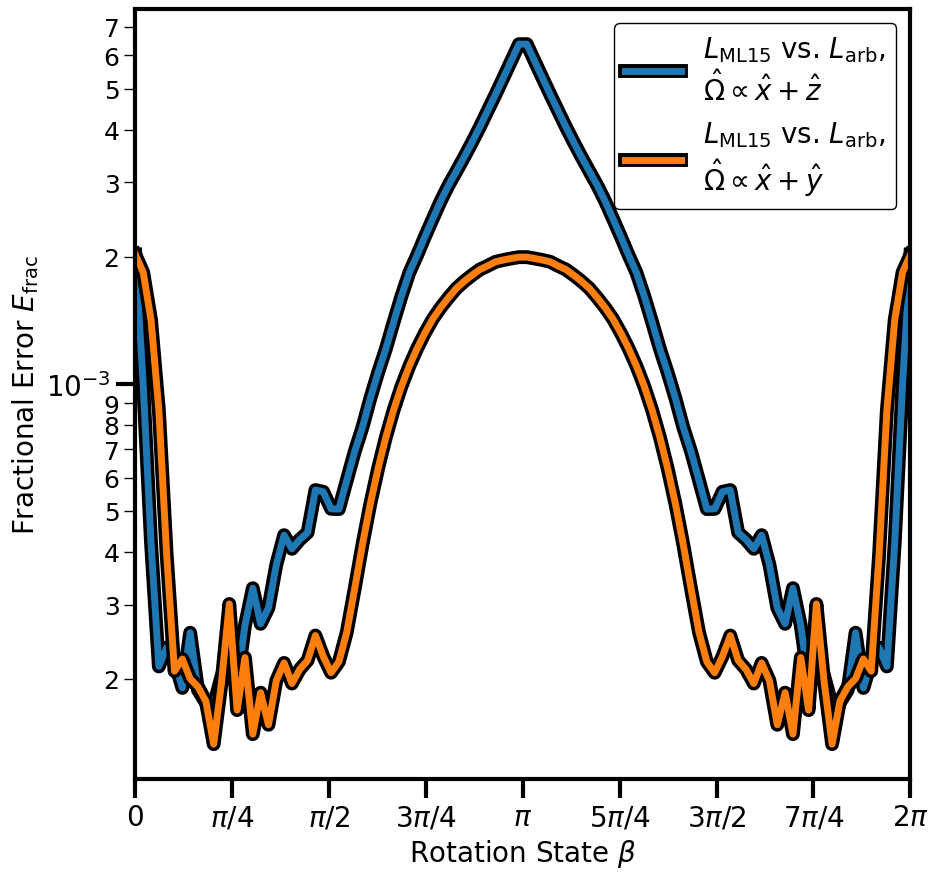

In [3]:
theta=[0]
phi=[np.pi/2]
psi=[0]

def fmt(x, pos):
    b=np.floor(np.log10(x))
    a=x/10**b
    return(r"{:.0f}".format(a,b))
    
beta=np.linspace(0,2*np.pi,1000)[None,:]

ml=(evolving_axis_lightcurve(theta,phi,psi,115,111,19,np.zeros_like(beta),beta))[0,:]
simple=fixed_axis_lightcurve(beta[0,:],115,111,19)

fig=plt.figure(figsize=(10,10))
ax=plt.gca()
#plt.plot(beta[0,:],np.abs((ml-simple)/simple))

theta=[0]
phi=[np.pi/4]
psi=[np.pi/2]
beta=np.linspace(0,2*np.pi,100)[None,:]

ml=(evolving_axis_lightcurve(theta,phi,psi,115,111,19,np.zeros_like(beta),beta))[0,:]
arb=arbitrary_axis_lightcurve(beta[0,:],115,111,19,rot=[1,0,1],obs=[1,0,0],N=150)

plt.plot(beta[0,:],np.abs((ml-arb)/arb),lw=5,path_effects=[pe.Stroke(linewidth=10, foreground='k'), pe.Normal()])

theta=[0]
phi=[np.pi/4]
psi=[0]
beta=np.linspace(0,2*np.pi,100)[None,:]

ml=(evolving_axis_lightcurve(theta,phi,psi,115,19,111,np.zeros_like(beta),beta))[0,:]
arb=arbitrary_axis_lightcurve(beta[0,:],115,19,111,rot=[1,1,0],obs=[1,0,0],N=150)

plt.plot(beta[0,:],np.abs((ml-arb)/arb),lw=5,path_effects=[pe.Stroke(linewidth=10, foreground='k'), pe.Normal()])
plt.yscale('log')

plt.legend(["$L_{\\rm ML15}$ vs. $L_{\\rm arb}$,\n$\\hat{\\Omega}\\propto\\hat{x}+\\hat{z}$",
            "$L_{\\rm ML15}$ vs. $L_{\\rm arb}$,\n$\\hat{\\Omega}\\propto\\hat{x}+\\hat{y}$"],
           loc='best',fancybox=True,edgecolor='black',facecolor='white',framealpha=1)
plt.xticks(np.pi*np.linspace(0, 2, 9),
           labels=[0, "$\\pi/4$", "$\\pi/2$", "$3\\pi/4$", "$\\pi$",
                   "$5\\pi/4$", "$3\\pi/2$", "$7\\pi/4$", "$2\\pi$"])
plt.xlabel(r"Rotation State $\beta$")
plt.ylabel(r"Fractional Error $E_{\rm frac}$")
plt.xlim([0,2*np.pi])
ax.yaxis.set_minor_formatter(ticker.FuncFormatter(fmt))
ax.tick_params(axis='y',which='minor',labelsize=18)

#fig.set_rasterized(True)

plt.savefig('../Figures and Paper/ml_comp.pdf',
           bbox_inches='tight',dpi=150)

In [4]:
from scipy.interpolate import interp1d

phase=pd.read_csv("../Lightcurves/Photometry/PhaseData.csv")
MJD=phase['MJD'].to_numpy()
datalpha=phase['Phase'].to_numpy()*np.pi/180

alpha=interp1d(MJD,datalpha,'linear')

In [5]:
belton=pd.read_csv("../Lightcurves/Photometry/1I_2017U1_lightcurve.csv",comment='#')

beltime=belton['corrMMJD'].to_numpy()
belmag=belton['corrm'].to_numpy()
belsig=belton['sigma'].to_numpy()
belalpha=belton['aPh'].to_numpy()

belton=np.array([beltime,belmag,belsig]).T

cutoff=78
octbeltime=beltime[beltime<cutoff]
octbelmag=belmag[beltime<cutoff]
octbelsig=belsig[beltime<cutoff]

cutoff=78
novbeltime=beltime[beltime>cutoff]
novbelmag=belmag[beltime>cutoff]
novbelsig=belsig[beltime>cutoff]

In [6]:
per=np.linspace(6,8,5)
theta=np.linspace(0,2*np.pi,5)
phi=np.linspace(0,np.pi/2,5)
psi=np.linspace(0,2*np.pi,5)
betinit=np.linspace(0,2*np.pi,5)
deltaV=[32]

PER,THET,PHI,PSI,BETI,DELTAV=np.meshgrid(per,theta,phi,psi,betinit,deltaV,indexing='ij')
PER=PER.flatten()
THET=THET.flatten()
PHI=PHI.flatten()
PSI=PSI.flatten()
BETI=BETI.flatten()
DELTAV=DELTAV.flatten()

chimin=1e25
chilist=[]

poctlist=[]
pnovlist=[]

dpoct=[]
dpnov=[]

for i in tqdm(range(PER.size)):
    try:
        evopopt,evopcov=curve_fit(evolvingHfunction,octbeltime,octbelmag,p0=[PER[i],THET[i],PHI[i],PSI[i],BETI[i],DELTAV[i]],
                            sigma=octbelsig,absolute_sigma=True,
                            bounds=([6,0,0,0,0,20],[8,2*np.pi,np.pi/2,2*np.pi,2*np.pi,40]),maxfev=500)

        chitest=chi2(evolvingHfunction(octbeltime,*evopopt),octbelmag,octbelsig)

        popt,thetaopt,phiopt,psiopt,biopt,delVopt=evopopt
        biopt=2*np.pi*((np.min(novbeltime)-np.min(octbeltime))%popt)/popt

        novpopt,novpcov=curve_fit(lambda time,p,bi,delV: evolvingHfunction(time,p,thetaopt,phiopt,psiopt,bi,delV),
                                  novbeltime,novbelmag,
                                  sigma=novbelsig,absolute_sigma=True,
                                  bounds=([5,0,20],[9,2*np.pi,40]),maxfev=1000)
        
        if chitest<chimin:
            chimin=chitest
            metaopt=evopopt
            metacov=evopcov

        if chitest<30000:
            chilist.append(chitest)
            poctlist.append(evopopt[0])
            dpoct.append(np.sqrt(evopcov[0,0]))
            pnovlist.append(novpopt[0])
            dpnov.append(np.sqrt(novpcov[0,0]))
    except: pass
    
print(chimin)
print(metaopt)
print(np.sqrt(np.diag(metacov)))

  0%|          | 0/3125 [00:00<?, ?it/s]

27160.068086223226
[ 7.3974597   1.55791165  1.41933543  4.39607842  4.39496192 32.15595513]
[0.00111447 0.01693448 0.00132289 0.00377192 0.00981767 0.01259704]


In [7]:
times=np.linspace(np.min(beltime),np.max(beltime)+0.1,10000)
curve=evolvingHfunction(times,*metaopt)

print(chi2(evolvingHfunction(octbeltime,*metaopt),octbelmag,octbelsig))

27160.068086223226


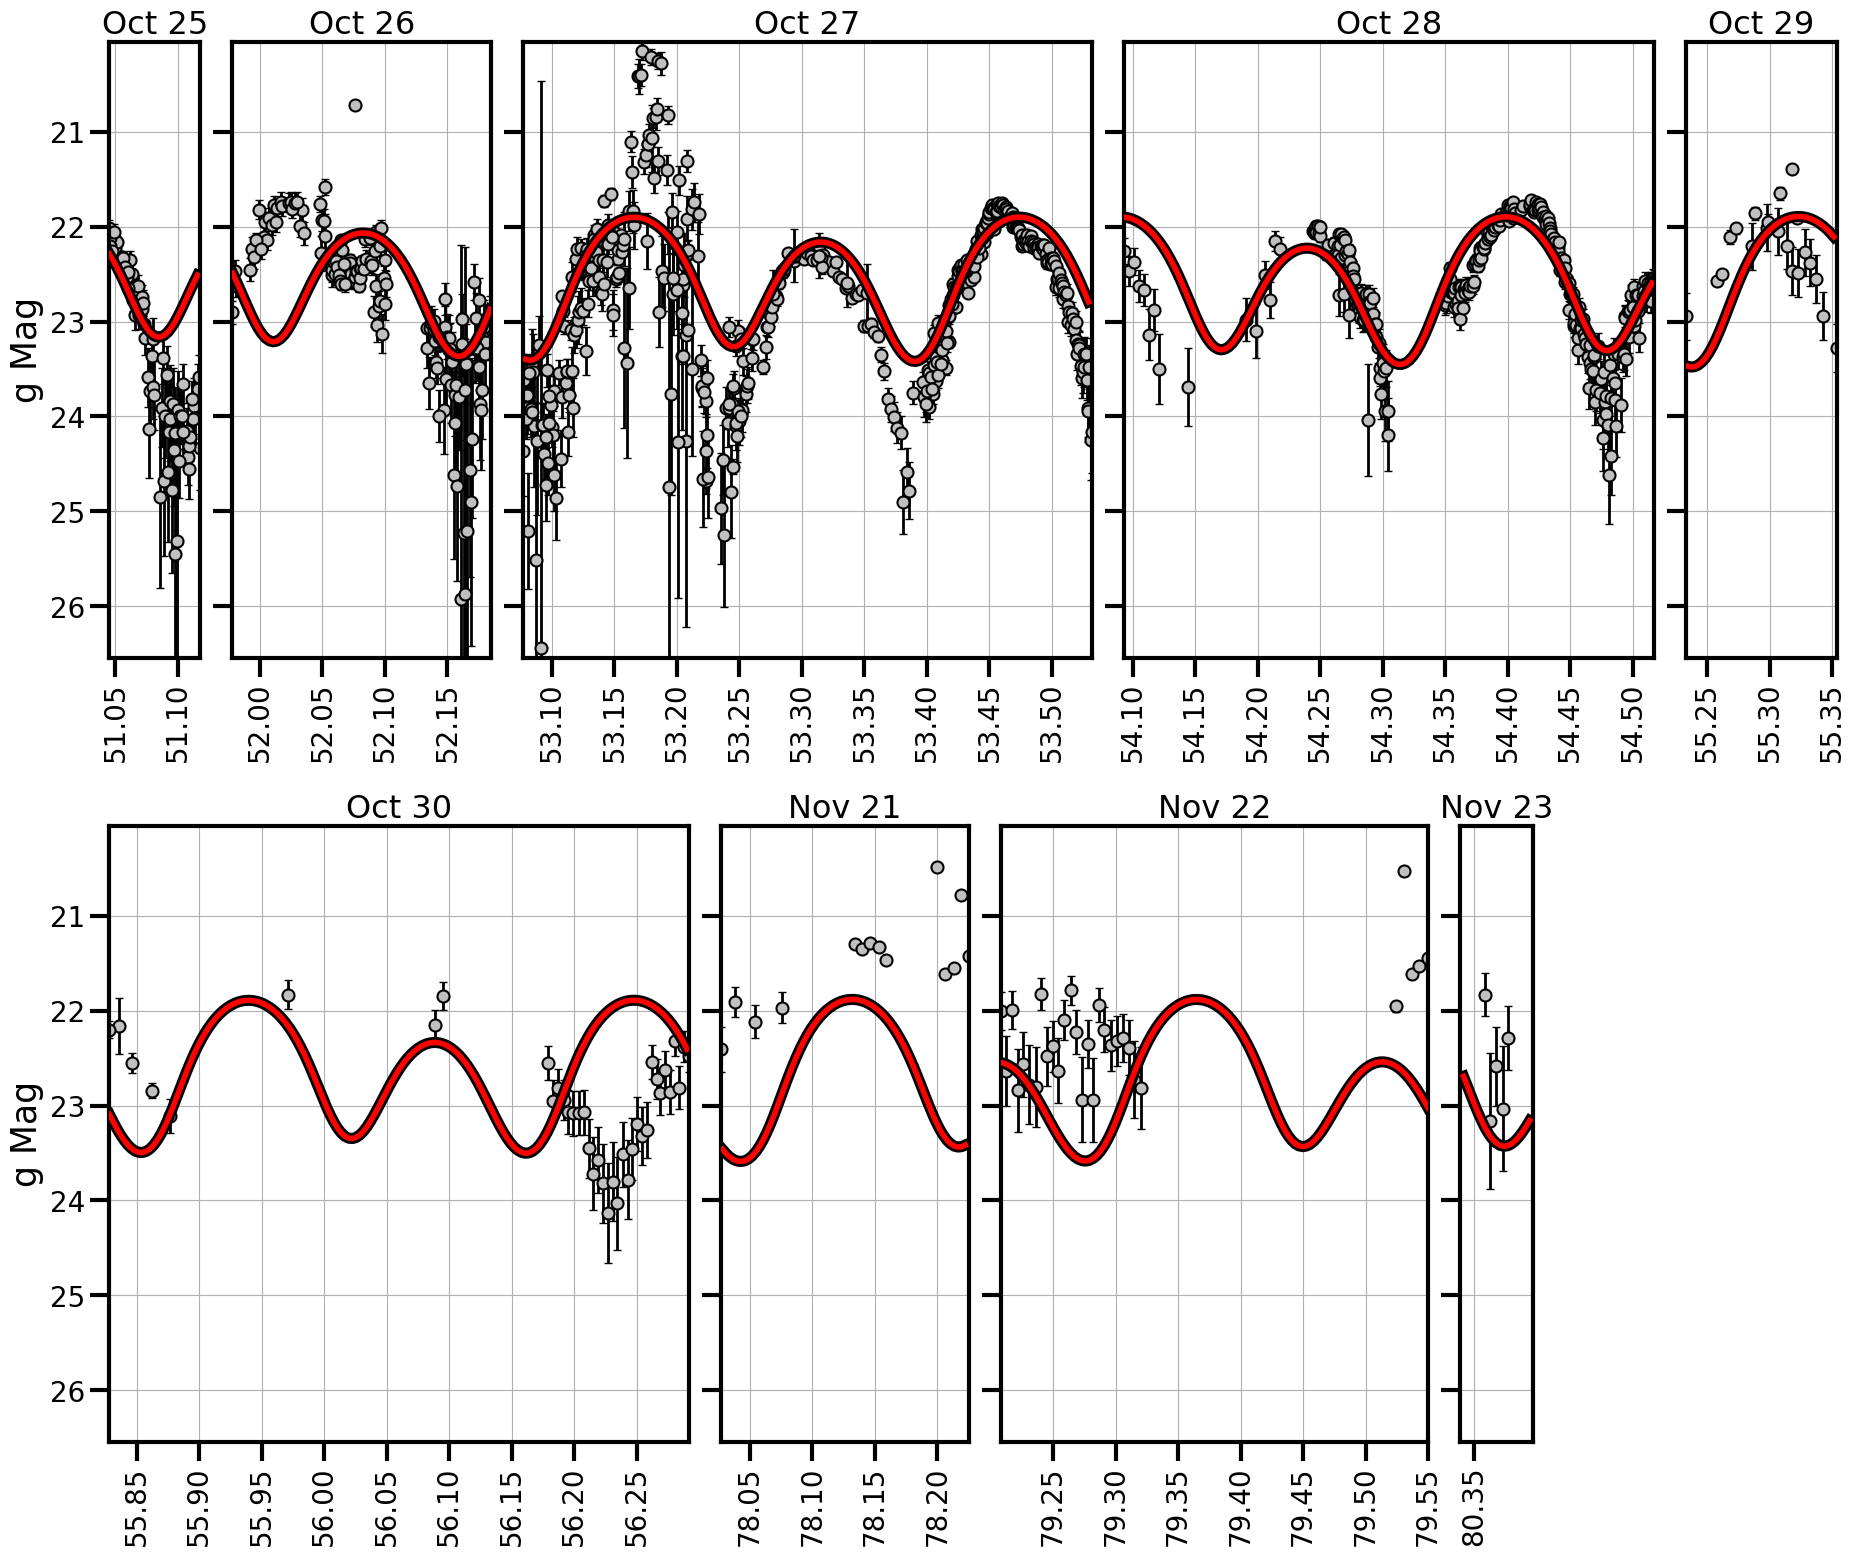

In [8]:
figx,figy=16,14
fig = plt.figure(figsize=(figx,figy))
ymin,ymax=np.min(belton[:,1])-0.1,np.max(belton[:,1])+0.1

labels=['Oct 25','Oct 26','Oct 27','Oct 28','Oct 29','Oct 30','Nov 21','Nov 22','Nov 23']
days=np.unique(beltime//1)-.25

limits=[]
for d in days:
    xmin=np.min(beltime[((beltime+.25)//1-.25)==d])
    xmax=np.max(beltime[((beltime+.25)//1-.25)==d])
    if (xmax-xmin)<0.05:
        xmin-=0.02
        xmax+=0.02
    limits.append((xmin,xmax))

axspace=0.02
tickspace=0.05

yspace=0.06

toprow=5
totalwidth=0
for i in range(5):
    totalwidth+=limits[i][1]-limits[i][0]
platescale=1/totalwidth

corner=0

axes=[]
for i in range(len(days)):
    xmin,xmax=limits[i]
    dx = (xmax-xmin)*platescale
    if i//5 == 0:
        ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
    else:
        ax=fig.add_axes([corner,0,dx,0.5-yspace])
    axes.append(ax)
    ax.set_xlim([xmin,xmax])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
    ax.set_title(labels[i],fontsize=23)
    ax.errorbar(belton[:,0][np.where((belton[:,0]<=xmax)&(belton[:,0]>=xmin))],
                  belton[:,1][np.where((belton[:,0]<=xmax)&(belton[:,0]>=xmin))],
                  yerr=belton[:,2][np.where((belton[:,0]<=xmax)&(belton[:,0]>=xmin))], 
                  fmt='none',ecolor='k',elinewidth=2,capsize=3,rasterized=True)
    ax.scatter(belton[:,0][np.where((belton[:,0]<=xmax)&(belton[:,0]>=xmin))],
                  belton[:,1][np.where((belton[:,0]<=xmax)&(belton[:,0]>=xmin))],
                  s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2,rasterized=True)
    ax.plot(times[np.where((times<=xmax)&(times>=xmin))],
                 curve[np.where((times<=xmax)&(times>=xmin))],
                 color='r',zorder=3,lw=4,path_effects=[pe.Stroke(linewidth=8, foreground='k'), pe.Normal()])
    plt.xticks(rotation=90)
    corner+=dx+axspace
    
    if i%5 == 0:
        ax.set_ylabel("g Mag", fontsize=25)
    else:
        ax.set_yticklabels([])
    
    if i==4: corner=0

for ax in axes:
    ax.grid(zorder=-10)
    ax.set_ylim([ymax,ymin])
    
#fig.set_rasterized(True)
    
plt.savefig('../Figures and Paper/evolving_axis_lightcurve.pdf',
           bbox_inches='tight',dpi=150)

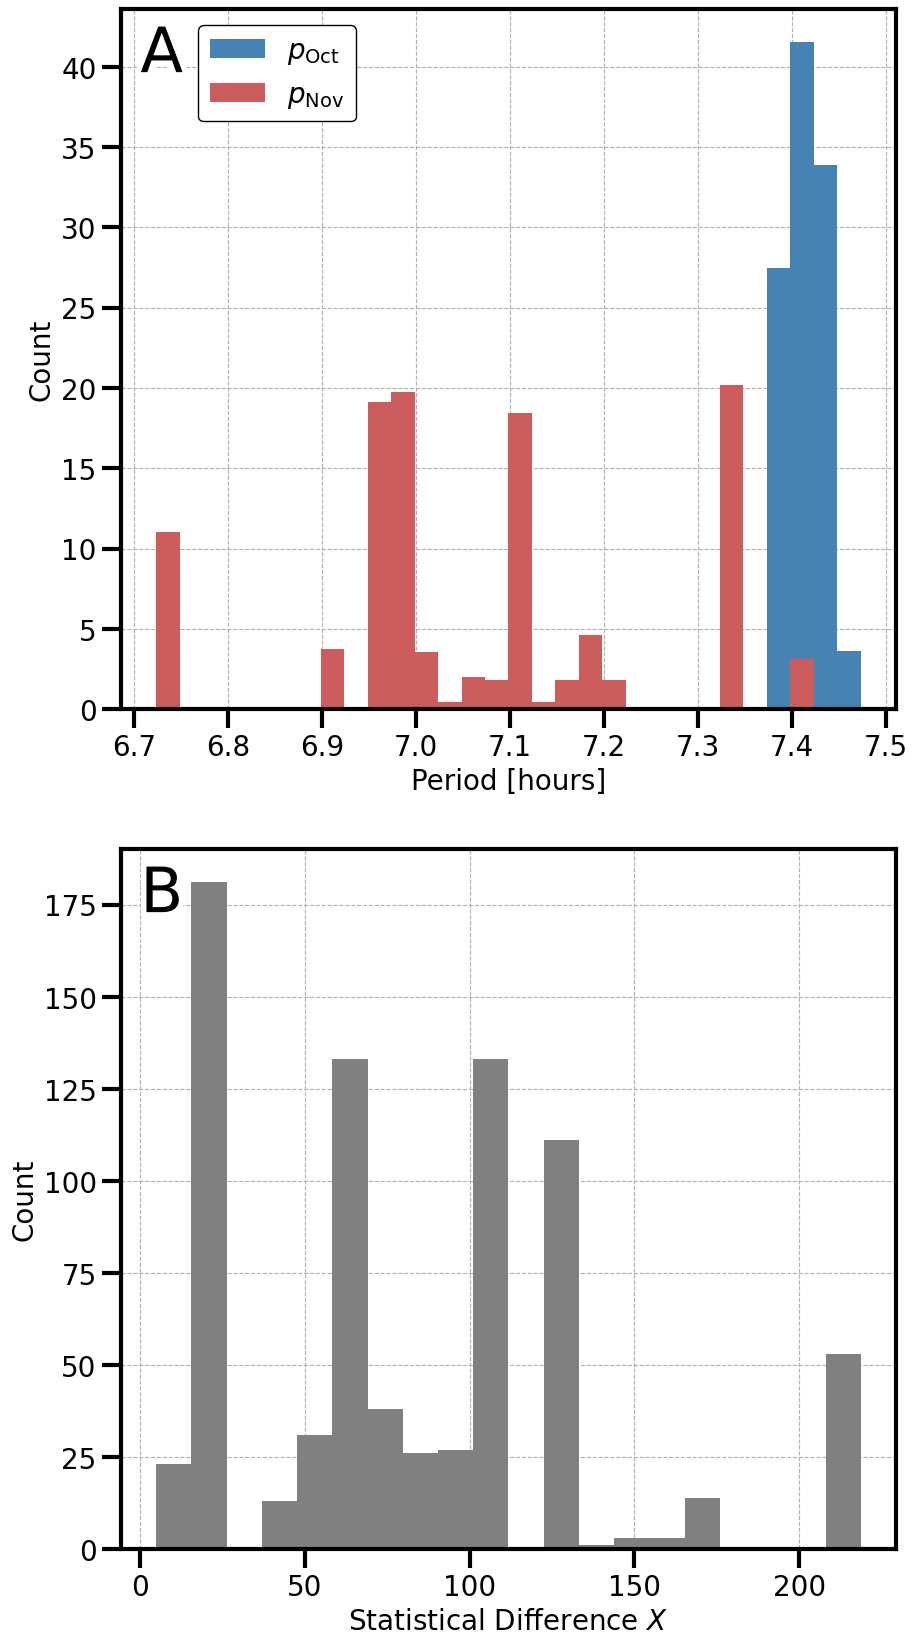

In [9]:
import matplotlib.ticker as ticker
import matplotlib.colors as colors

poctlist=np.array(poctlist)
pnovlist=np.array(pnovlist)

dpoct=np.array(dpoct)
dpnov=np.array(dpnov)

fig, axs = plt.subplots(2,1,figsize=(10,20))

binwidth=0.025
axs[0].hist(poctlist,density=False,weights=1/poctlist,color='steelblue',bins=np.arange(min(pnovlist), max(poctlist) + binwidth, binwidth),
            alpha=1,histtype='stepfilled',log=False,lw=4,zorder=2,label="$p_\\mathrm{Oct}$")
axs[0].hist(pnovlist,density=False,weights=1/pnovlist,color='indianred',bins=np.arange(min(pnovlist), max(poctlist) + binwidth, binwidth),
            alpha=1,histtype='stepfilled',log=False,lw=4,zorder=2,label="$p_\\mathrm{Nov}$")

axs[0].grid(linestyle='dashed',zorder=0)
axs[0].set_xlabel("Period [hours]")
axs[0].set_ylabel("Count")
axs[0].text(0.025,0.91,"A",fontsize=45,transform=axs[0].transAxes,
           path_effects=[pe.Stroke(linewidth=8, foreground='w'), pe.Normal()])
axs[0].legend(loc=(.1,.84),fancybox=True,edgecolor='black',facecolor='white',framealpha=1)

sigdiff=np.abs(poctlist-pnovlist)/np.sqrt(dpoct**2+dpnov**2)
axs[1].hist(sigdiff,bins=20,density=False,color='gray',
            histtype='stepfilled',log=False,zorder=2)
#axs[1].scatter(sigdiff,poct-pnov,color='k',s=75,zorder=2)
axs[1].set_xlabel(r"Statistical Difference $X$")
axs[1].set_ylabel(r"Count")
axs[1].grid(linestyle='dashed',zorder=0)
axs[1].text(0.025,0.91,"B",fontsize=45,transform=axs[1].transAxes,
           path_effects=[pe.Stroke(linewidth=8, foreground='w'), pe.Normal()])

axs[0].set_zorder(5)
axs[1].set_zorder(5)

#fig.set_rasterized(True)

plt.savefig("../Figures and Paper/period_comp_hist.pdf",
           bbox_inches='tight',dpi=150)

In [10]:
print("X:",np.cos(metaopt[2]))
print("Y:",np.sin(metaopt[2])*np.cos(metaopt[3]))
print("Z:",np.sin(metaopt[2])*np.sin(metaopt[3]))

print("Minimum:", np.min(sigdiff))
print("Maximum:", np.max(sigdiff))

print("Optimal Axis Sig Diff:",sigdiff[np.where(chilist==np.min(chilist))])

print("Opt October Period:",poctlist[np.where(chilist==np.min(chilist))])
pmetanov=pnovlist[np.where(chilist==np.min(chilist))]
print("Opt November Period:",pmetanov,r"$\pm$",dpnov[np.where(chilist==np.min(chilist))])

X: 0.15088246200364733
Y: -0.3075011467314967
Z: -0.9395091949622061
Minimum: 4.862765345609593
Maximum: 218.67024340231512
Optimal Axis Sig Diff: [20.84615065]
Opt October Period: [7.3974597]
Opt November Period: [7.19101687] $\pm$ [0.00984025]


In [11]:
def testingHfunction(time,p,theta,phi,psi,betainit,deltaV,alpha):
    p=p/24
    beta=2*np.pi*((time-np.min(time))%p)/p
    curve=deltaV-2.5*np.log10(evolving_axis_lightcurve(theta,phi,psi,115,111,19,alpha,beta-betainit))[0,:]
    return(curve)

7.397459700436597
[ 2.21757422 31.37804612]
[0.09397884 0.07699171]


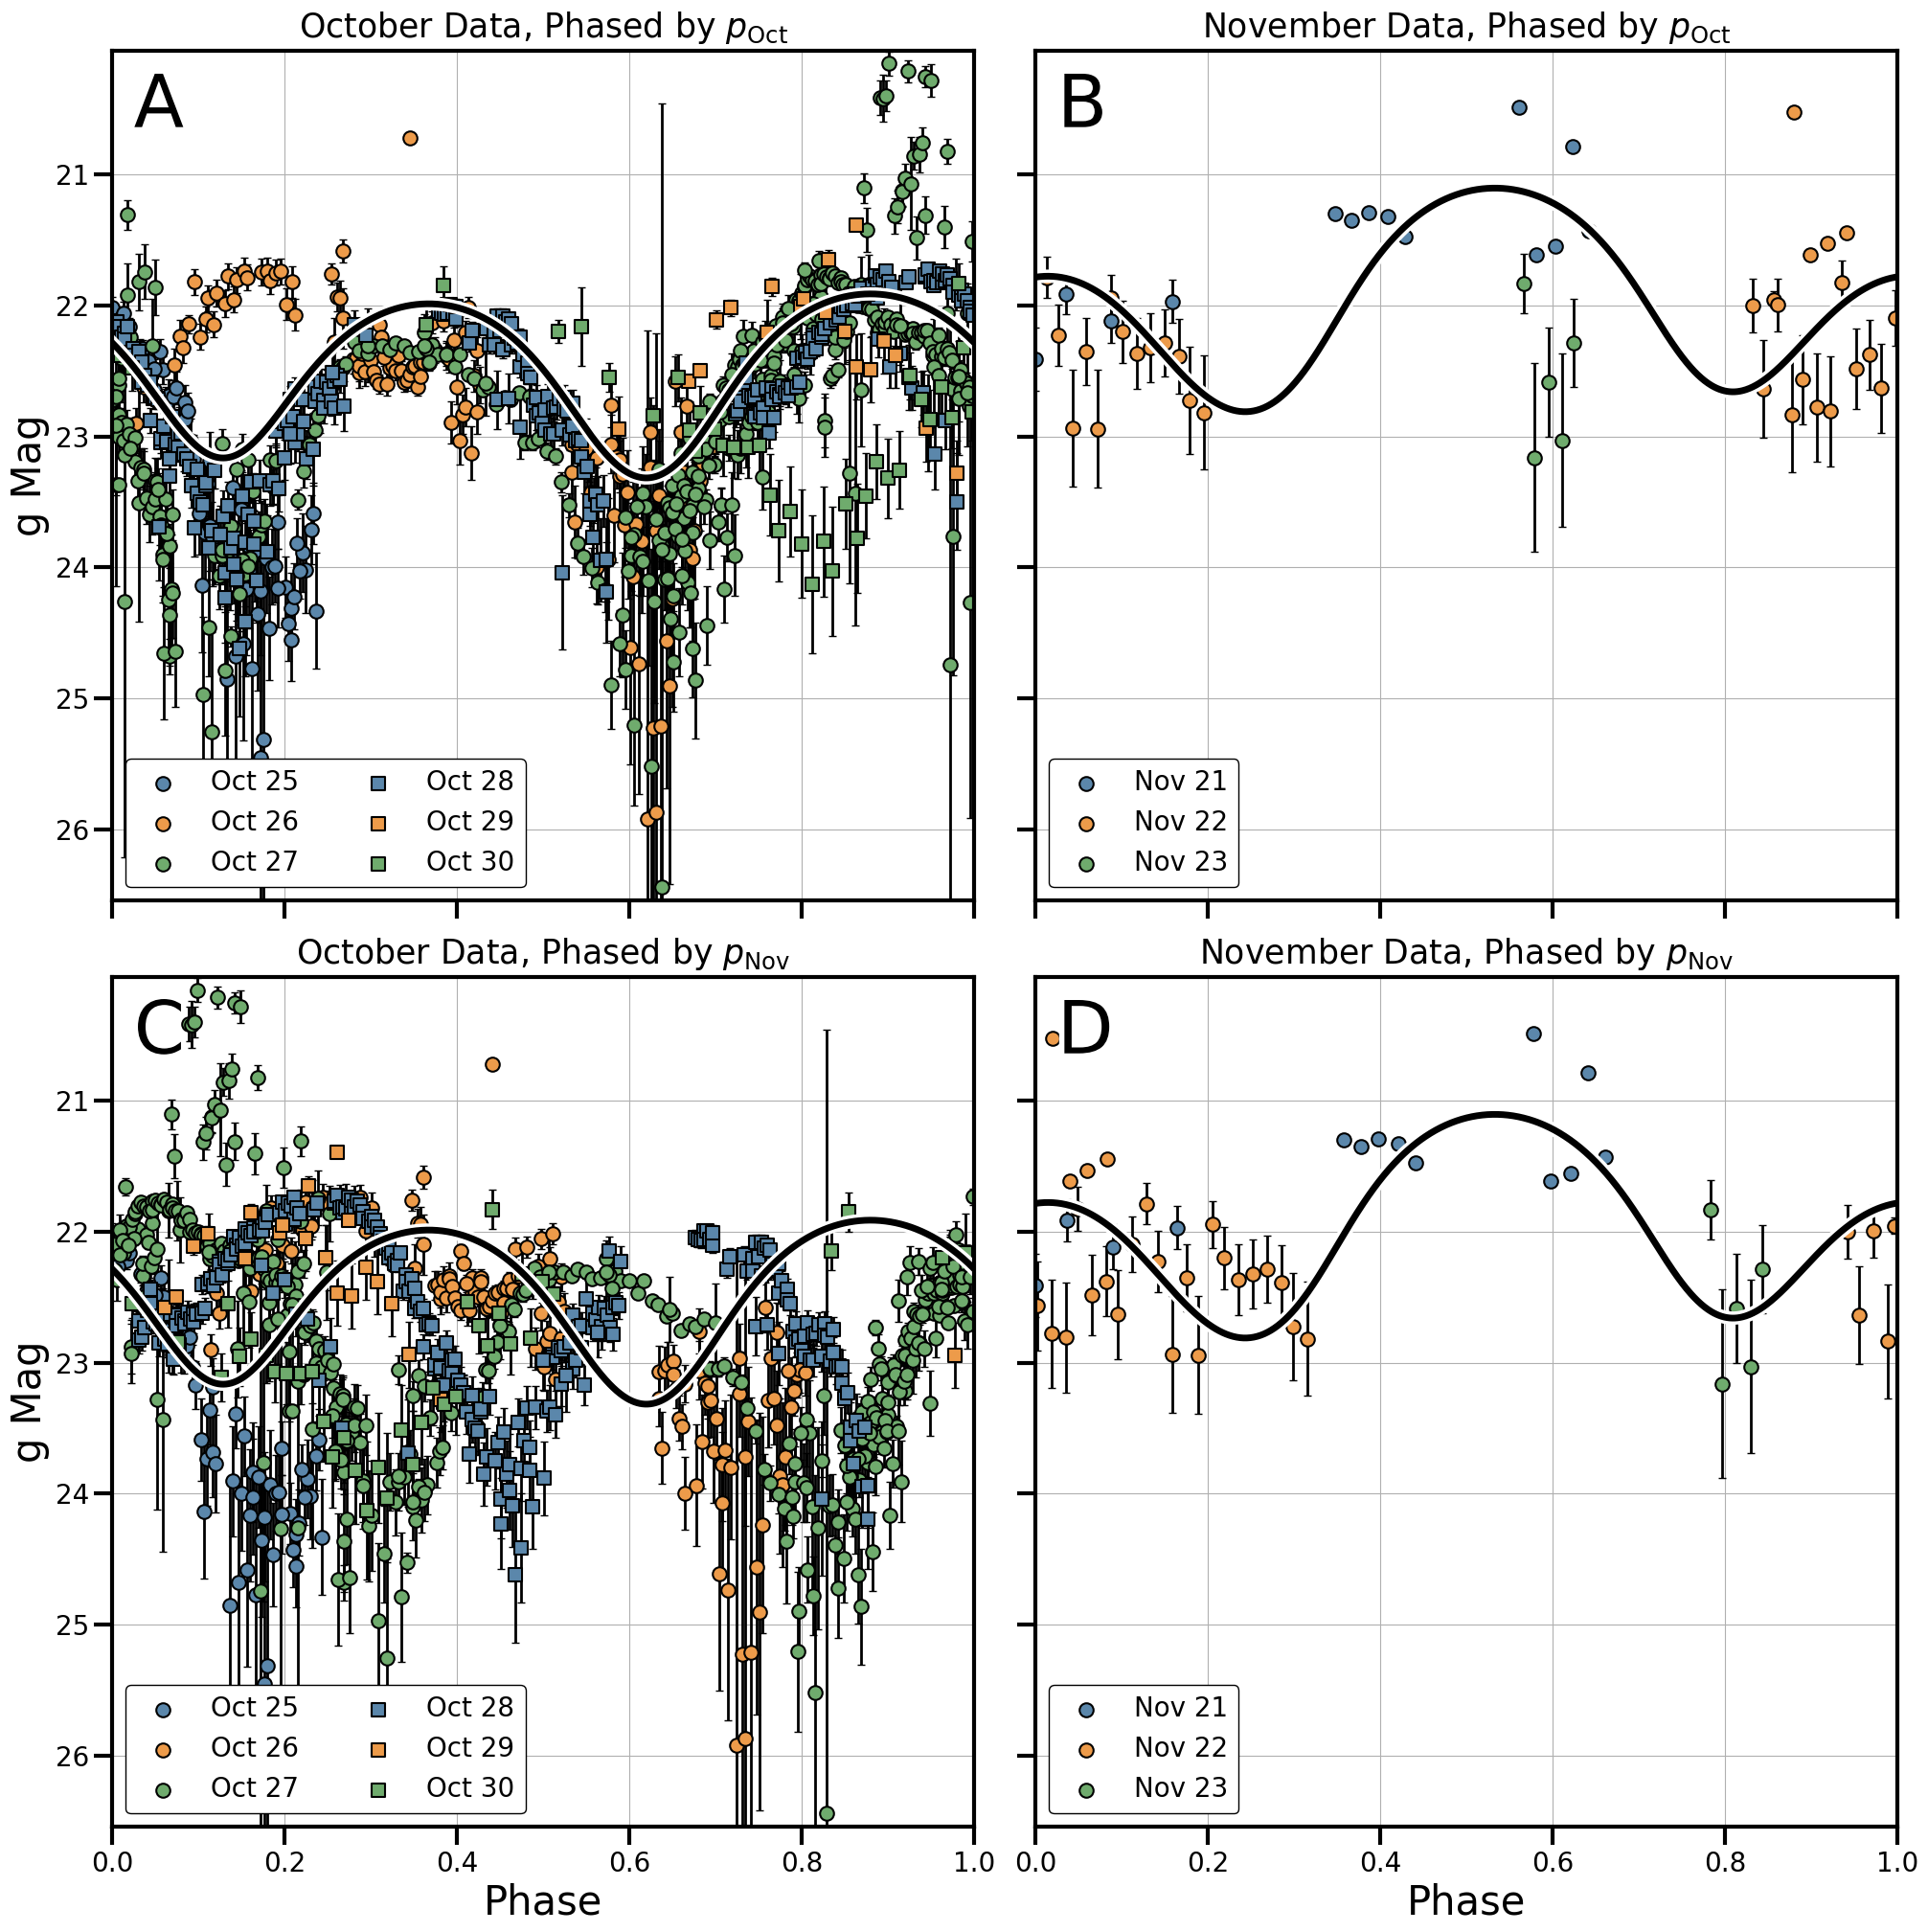

In [19]:
import matplotlib

cutoff=78
octbeltime=beltime[beltime<cutoff]
octbelmag=belmag[beltime<cutoff]
octbelsig=belsig[beltime<cutoff]

novbeltime=beltime[beltime>cutoff]
novbelmag=belmag[beltime>cutoff]
novbelsig=belsig[beltime>cutoff]

octlabels=['Oct 25','Oct 26','Oct 27','Oct 28','Oct 29','Oct 30']
novlabels=['Nov 21','Nov 22','Nov 23']
octdays=np.unique((octbeltime+.25)//1)-.25
novdays=np.unique((novbeltime+.25)//1)-.25

octlimits=[]
for d in octdays:
    xmin=np.min(beltime[((beltime+.25)//1-.25)==d])
    xmax=np.max(beltime[((beltime+.25)//1-.25)==d])
    if (xmax-xmin)<0.05:
        xmin-=0.02
        xmax+=0.02
    octlimits.append((xmin,xmax))

novlimits=[]
for d in novdays:
    xmin=np.min(beltime[((beltime+.25)//1-.25)==d])
    xmax=np.max(beltime[((beltime+.25)//1-.25)==d])
    if (xmax-xmin)<0.05:
        xmin-=0.02
        xmax+=0.02
    novlimits.append((xmin,xmax))

popt,thetaopt,phiopt,psiopt,biopt,delVopt=metaopt
nbiopt=2*np.pi*((np.min(novbeltime)-np.min(octbeltime))%popt)/popt

novpopt,novpcov=curve_fit(lambda time,bi,delV: evolvingHfunction(time,pmetanov,thetaopt,phiopt,psiopt,bi,delV),
                          novbeltime,novbelmag,p0=[biopt,delVopt],
                          #sigma=novbelsig,absolute_sigma=True,
                          bounds=([0,20],[2*np.pi,40]),maxfev=500)

#cols=np.tile(['#377eb8', '#ff7f00', '#4daf4a'],3)
cols=np.tile(['#5b87ab', '#ed9b4a', '#6fab6d'],3)
shapes=np.repeat(['o','s','v'],3,axis=0)
sizes=np.repeat([110,90,150],3,axis=0)

print(popt)
print(novpopt)
print(np.sqrt(np.diag(novpcov)))
#novpopt=np.append(novpopt,delVopt)

poct=popt/24
pnov=pmetanov[0]/24

fig,axes=plt.subplots(2,2,figsize=(20,20),constrained_layout=True,sharex=True,sharey=True)
axes=axes.flatten()

ymax,ymin=np.max(belmag)+0.1,np.min(belmag)-0.1
axes[0].set_ylim([ymax,ymin])
axes[0].set_xlim([0,1])

octtime=np.linspace(np.min(octbeltime),np.min(octbeltime)+poct,1000,endpoint=False)
octcurve=evolvingHfunction(octtime,*metaopt)
octphase=(((octbeltime-np.min(octbeltime))%(poct)/poct))

uni,datcolors=np.unique(np.int32((octbeltime-np.min(octbeltime))//poct),return_inverse=True)

ax=axes[0]
ax.errorbar(octphase,octbelmag,yerr=octbelsig,fmt='none',ecolor='k',elinewidth=2,capsize=3,rasterized=True)
for i in range(len(octlabels)):
    xmin,xmax=octlimits[i]
    inds=(octbeltime>=xmin)&(octbeltime<=xmax)
    ax.scatter(octphase[inds],octbelmag[inds],s=sizes[i],edgecolors='k',linewidths=1.5,
               marker=shapes[i],color=cols[i],label=octlabels[i],zorder=2,rasterized=True)
ax.plot((((octtime-np.min(octtime))%(poct))/poct),octcurve,c='k',lw=5,
        path_effects=[pe.Stroke(linewidth=10, foreground='w'), pe.Normal()])
ax.set_title(r"October Data, Phased by $p_\mathrm{Oct}$", fontsize=25, pad=10)
ax.set_ylabel("g Mag",fontsize=30)
ax.legend(loc='lower left',ncol=2,edgecolor='black',framealpha=1,facecolor='white',fancybox=True) 

novtime=np.linspace(np.min(novbeltime),np.min(novbeltime)+poct,1000,endpoint=False)
novcurve=evolvingHfunction(novtime,poct*24,thetaopt,phiopt,psiopt,novpopt[0],novpopt[1])
novphase=(((novbeltime-np.min(novbeltime))%(poct)/poct))

ax=axes[1]
ax.errorbar(novphase,novbelmag,yerr=novbelsig,fmt='none',ecolor='k',elinewidth=2,capsize=3,rasterized=True)
for i in range(len(novlabels)):
    xmin,xmax=novlimits[i]
    inds=(novbeltime>=xmin)&(novbeltime<=xmax)
    ax.scatter(novphase[inds],novbelmag[inds],s=sizes[i],edgecolors='k',linewidths=1.5,
               marker=shapes[i],color=cols[i],label=novlabels[i],zorder=2,rasterized=True)
ax.plot((((novtime-np.min(novtime))%(poct))/poct),novcurve,c='k',lw=5,
       path_effects=[pe.Stroke(linewidth=10, foreground='w'), pe.Normal()])
ax.set_title(r"November Data, Phased by $p_\mathrm{Oct}$", fontsize=25, pad=10)
ax.legend(loc='lower left',edgecolor='black',framealpha=1,facecolor='white',fancybox=True)
          
octtime=np.linspace(np.min(octbeltime),np.min(octbeltime)+pnov,1000,endpoint=False)
octcurve=evolvingHfunction(octtime,pnov*24,*metaopt[1:])
octphase=(((octbeltime-np.min(octbeltime))%(pnov)/pnov))

ax=axes[2]
ax.errorbar(octphase,octbelmag,yerr=octbelsig,fmt='none',ecolor='k',elinewidth=2,capsize=3,rasterized=True)
for i in range(len(octlabels)):
    xmin,xmax=octlimits[i]
    inds=(octbeltime>=xmin)&(octbeltime<=xmax)
    ax.scatter(octphase[inds],octbelmag[inds],s=sizes[i],edgecolors='k',linewidths=1.5,
               marker=shapes[i],color=cols[i],label=octlabels[i],zorder=2,rasterized=True)
ax.plot((((octtime-np.min(octtime))%(pnov))/pnov),octcurve,c='k',lw=5,
       path_effects=[pe.Stroke(linewidth=10, foreground='w'), pe.Normal()])
ax.set_title(r"October Data, Phased by $p_\mathrm{Nov}$", fontsize=25, pad=10)
ax.set_xlabel("Phase",fontsize=30)
ax.set_ylabel("g Mag",fontsize=30)
ax.legend(loc='lower left',ncol=2,edgecolor='black',framealpha=1,facecolor='white',fancybox=True)
       
novtime=np.linspace(np.min(novbeltime),np.min(novbeltime)+pnov,1000,endpoint=False)
novcurve=evolvingHfunction(novtime,pnov*24,thetaopt,phiopt,psiopt,novpopt[0],novpopt[1])
novphase=(((novbeltime-np.min(novbeltime))%(pnov)/pnov))

ax=axes[3]
ax.errorbar(novphase,novbelmag,yerr=novbelsig,fmt='none',ecolor='k',elinewidth=2,capsize=3,rasterized=True)
for i in range(len(novlabels)):
    xmin,xmax=novlimits[i]
    inds=(novbeltime>=xmin)&(novbeltime<=xmax)
    ax.scatter(novphase[inds],novbelmag[inds],s=sizes[i],edgecolors='k',linewidths=1.5,
               marker=shapes[i],color=cols[i],label=novlabels[i],zorder=2,rasterized=True)
ax.plot((((novtime-np.min(novtime))%(pnov))/pnov),novcurve,c='k',lw=5,
       path_effects=[pe.Stroke(linewidth=10, foreground='w'), pe.Normal()])
ax.set_title(r"November Data, Phased by $p_\mathrm{Nov}$",fontsize=25, pad=10)
ax.set_xlabel("Phase",fontsize=30)
ax.legend(loc='lower left',edgecolor='black',framealpha=1,facecolor='white',fancybox=True)

labels="ABCD"
for i,ax in enumerate(axes):
    ax.grid()
    ax.text(0.025,.91,labels[i],fontsize=55,transform=ax.transAxes,
            path_effects=[pe.Stroke(linewidth=8, foreground='w'), pe.Normal()]) 

#fig.set_rasterized(True)
    
plt.savefig("../Figures and Paper/phased_lightcurve.pdf",
           bbox_inches='tight',dpi=150)